In [2]:
import numpy as np

# Load training data
Xtrain = np.loadtxt('Xtrain.csv')

# Load training labels
Ytrain = np.loadtxt('Ytrain.csv')

# Load test data
Xtest = np.loadtxt('Xtest.csv')

## Question No. 3: Cross-validation of SVM and RFs

*Use 5-fold stratified cross-validation over training data to choose an optimal classifier between: SVMs (linear, polynomial kernels and Radial Basis Function Kernels) and Random Forest Classifiers. Be sure to tune the hyperparameters of each classifier type (C and kernel type and kernel hyper-parameters for SVMs, the number of trees, depth of trees etc. for the Random Forests etc). Report the cross validation results (mean and standard deviation of accuracy, balanced accuracy, AUC-ROC and AUC-PR across fold) of your best model. You may look into grid search as well as ways of pre-processing data.*

### i. Selecting the Optimal Classifier

*Write your strategy for selecting the optimal classifier. Show code to demonstrate the results for each classifier.*

Intuitively, SVM may benefit more from using a scaler for data preprocessing compared to Random Forest.

1. **Distance-based Decision Boundary**: SVM aims to find a decision boundary that maximizes the margin between different classes. This boundary is often influenced by the distances between data points. Scaling ensures that all features contribute proportionally to the distance calculations, preventing features with larger scales from dominating the decision.

2. **Sensitivity to Feature Scales**: SVM is sensitive to the scales of features, especially when using radial basis function (RBF) kernels. Features with larger scales may have a stronger impact, potentially leading to a bias. Scaling helps in ensuring that all features have a similar influence on the model, making the optimization process more effective.

In contrast, Random Forest constructs decision trees based on feature thresholds and doesn't rely on distance metrics. The ensemble nature of RF, where multiple trees are combined, makes it less sensitive to individual feature scales.

<br>

We start by performing grid search on the raw data without preprocessing using a scaler. We use Matthews correlation coefficient as the evaluation metric and perform 5-fold stratified cross-validation over training data.

For SVMs, we use these initial hyperparameter ranges for the grid search:

- Kernel: ['linear', 'poly', 'rbf']
- C (Regularization parameter): [0.001, 0.01, 0.1, 1, 10, 100, 1000]
- Degree (for 'poly' kernel): [2, 3, 4, 5]
- Gamma (for 'rbf' kernel): [0.001, 0.01, 0.1, 1, 10, 100, 1000]

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def grid_search(classifier, param_grid, X, Y):
    # Initialize GridSearchCV
    grid_search_cv = GridSearchCV(classifier, param_grid=param_grid, \
        scoring='matthews_corrcoef', cv=5, n_jobs=-1)
    
    # Perform grid search on the training data
    grid_search_cv.fit(X, Y)
    
    return grid_search_cv

def sorted_score(grid_search_cv):
    # Get the results of the grid search
    results = grid_search_cv.cv_results_

    # Create a list to store relevant information
    relevant_info = []

    # Iterate through each parameter combination
    for i in range(len(results['params'])):
        params = results['params'][i]
        mean_mcc = results['mean_test_score'][i]
        std_mcc = results['std_test_score'][i]
        relevant_info.append({'params': params, 'mean_mcc': mean_mcc, 'std_mcc': std_mcc})

    # Sort the relevant information by mean MCC in descending order
    relevant_info.sort(key=lambda x: x['mean_mcc'], reverse=True)

    return relevant_info

In [5]:
# Define the parameter grid for SVM
param_grid_svm = [
    {
        'kernel': ['linear'],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    {
        'kernel': ['poly'],
        'degree': [2, 3, 4, 5],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    {
        'kernel': ['rbf'],
        'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    }
]

# Create the SVM classifier and perform grid search
svm_search = grid_search(SVC(probability=True), param_grid_svm, Xtrain, Ytrain)

# Print the best parameters
print("Parameters for SVM", svm_search.best_params_)

# Print the best cross-validated MCC
print("MCC for SVM:", svm_search.best_score_)

Best Parameters for SVM {'C': 100, 'degree': 2, 'kernel': 'poly'}
Best MCC for SVM: 0.5840522412675488


The best parameters obtained from grid search on the raw data are 'C': 100, 'degree': 2, 'kernel': 'poly'. This implies that the optimal SVM model is a polynomial kernel SVM with the regularization parameter set to 100 and the degree set to 2. The model achieved an average MCC score of 0.5841 on cross-validation, surpassing the performance of the previous KNN model.

In [15]:
relevant_info = sorted_score(svm_search)

# Print the sorted information
for info in relevant_info:
    print(f"{str(info['params']):<50} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'C': 100, 'degree': 2, 'kernel': 'poly'}          Mean: 0.5841          Std: 0.0932
{'C': 1000, 'degree': 3, 'kernel': 'poly'}         Mean: 0.5794          Std: 0.0686
{'C': 1000, 'degree': 2, 'kernel': 'poly'}         Mean: 0.5749          Std: 0.0860
{'C': 100, 'degree': 3, 'kernel': 'poly'}          Mean: 0.5640          Std: 0.0536
{'C': 1000, 'degree': 4, 'kernel': 'poly'}         Mean: 0.5626          Std: 0.0748
{'C': 10, 'degree': 2, 'kernel': 'poly'}           Mean: 0.5325          Std: 0.0652
{'C': 100, 'degree': 4, 'kernel': 'poly'}          Mean: 0.5324          Std: 0.0335
{'C': 1000, 'degree': 5, 'kernel': 'poly'}         Mean: 0.5145          Std: 0.0594
{'C': 10, 'degree': 3, 'kernel': 'poly'}           Mean: 0.5048          Std: 0.0813
{'C': 1, 'degree': 4, 'kernel': 'poly'}            Mean: 0.4933          Std: 0.0569
{'C': 1, 'degree': 5, 'kernel': 'poly'}            Mean: 0.4761          Std: 0.0534
{'C': 100, 'degree': 5, 'kernel': 'poly'}          Mean: 0.4735  

Sorting the parameter combinations based on the MCC score, it can be observed that the polynomial kernel SVM performs the best overall on the raw data, followed by the linear kernel, and the RBF kernel performs the worst. Note that certain parameter combinations have MCC values equal to 0, indicating their predictive performance is the same as random guessing.

<br>

For Random Forest, we use these initial hyperparameter ranges:

- Number of Trees: [50, 100, 200, 300]
- Maximum Depth of Trees: [None, 10, 20, 30]
- Minimum Samples Split: [2, 5, 10]
- Minimum Samples Leaf: [1, 2, 4]

In [35]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the RF classifier and perform grid search
rf_search = grid_search(RandomForestClassifier(random_state=42), param_grid_rf, Xtrain, Ytrain)

# Print the best parameters
print("Parameters for RF", rf_search.best_params_)

# Print the best cross-validated MCC
print("MCC for RF:", rf_search.best_score_)

Parameters for RF {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MCC for RF: 0.5143262645404302


The optimal parameters for the random forest model obtained from grid search suggests that the model prefers using a relatively large number of trees, with each tree having unrestricted depth, and each leaf node containing at least one sample. Internal nodes need at least two samples to split. Overall, it represents a flexible and complex random forest model.

In [36]:
relevant_info = sorted_score(rf_search)

# Print the sorted information
print("Top 20 parameter combinations:\n" + '-'*117)
for info in relevant_info[:20]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

print("\nBottom 20 parameter combinations:\n" + '-'*117)
for info in relevant_info[-20:]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

Top 20 parameter combinations:
---------------------------------------------------------------------------------------------------------------------
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}    Mean: 0.5143   Std: 0.0554
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5143   Std: 0.0554
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5143   Std: 0.0554
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}    Mean: 0.5084   Std: 0.0505
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}    Mean: 0.5021   Std: 0.0560
{'max_depth': 20, 'min_sa

Sorting the parameter combinations based on the MCC score, it can be observed that the MCC scores of the random forest range roughly between 0.45 and 0.52. Adjusting the parameters has limited impact on the model's performance. The optimal performance still surpasses that of KNN, but is not so good as the best performance of SVM.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance (L1), 2 for Euclidean distance (L2)
}


# Create the KNN classifier and perform grid search
knn_search = grid_search(KNeighborsClassifier(), param_grid_knn, Xtrain, Ytrain)

# Print the best parameters
print("Parameters for KNN", knn_search.best_params_)

# Print the best cross-validated MCC
print("MCC for KNN:", knn_search.best_score_)

Parameters for KNN {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
MCC for KNN: 0.5045358831934272


In [ ]:
relevant_info = sorted_score(knn_search)

# Print the sorted information
for info in relevant_info:
    print(f"{str(info['params']):<50} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}  Mean: 0.5045          Std: 0.0321
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}  Mean: 0.5040          Std: 0.0433
{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}  Mean: 0.5006          Std: 0.0410
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}  Mean: 0.4942          Std: 0.0662
{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}  Mean: 0.4942          Std: 0.0287
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}  Mean: 0.4921          Std: 0.0190
{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}  Mean: 0.4898          Std: 0.0512
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}  Mean: 0.4883          Std: 0.0179
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}   Mean: 0.4847          Std: 0.0377
{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}   Mean: 0.4814          Std: 0.0295
{'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}   Mean: 0.4719          Std: 0.0108
{'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}   Mean: 0.4676  

The optimal KNN classifier found for raw dataset considers the labels of the five nearest neighbors using the Manhattan distance. Assigning higher importance to closer neighbors generally gives better performance than treating them with equal weights, while the number of neighbours taken into consideration and the distance function seem to matter less.

<br>

We then apply the same grid search strategies, but this time on preprocessed data using standard scaling.

In [3]:
from sklearn.preprocessing import StandardScaler

standard = StandardScaler()
Xtrain_standard = standard.fit_transform(Xtrain)
Xtest_standard = standard.transform(Xtest)

In [10]:
# Perform SVM grid search on scaled dataset
standard_svm_search = grid_search(SVC(probability=True), param_grid_svm, Xtrain_standard, Ytrain)

# Print the best parameters
print("Parameters for SVM on scaled dataset", standard_svm_search.best_params_)

# Print the best cross-validated MCC
print("MCC for SVM on scaled dataset:", standard_svm_search.best_score_)

Best Parameters for SVM on scaled dataset {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best MCC for SVM on scaled dataset: 0.6063818846996674


The best parameters obtained from grid search on the scaled data are 'C': 100, 'gamma': 0.001, 'kernel': 'rbf'. This implies that the optimal SVM model is a Radial Basis Function kernel SVM with the regularization parameter set to 100 and gamma value set to 0.001. We may want to try smaller gamma values to see if the performance can be further improved.

In [11]:
relevant_info = sorted_score(standard_svm_search)

# Print the sorted information
for info in relevant_info:
    print(f"{str(info['params']):<50} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}        Mean: 0.6064          Std: 0.0552
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}       Mean: 0.6064          Std: 0.0552
{'C': 10, 'degree': 2, 'kernel': 'poly'}           Mean: 0.5985          Std: 0.0492
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}         Mean: 0.5976          Std: 0.0462
{'C': 1000, 'degree': 2, 'kernel': 'poly'}         Mean: 0.5894          Std: 0.0180
{'C': 100, 'degree': 2, 'kernel': 'poly'}          Mean: 0.5855          Std: 0.0180
{'C': 1000, 'degree': 4, 'kernel': 'poly'}         Mean: 0.5765          Std: 0.0235
{'C': 100, 'degree': 3, 'kernel': 'poly'}          Mean: 0.5687          Std: 0.0504
{'C': 100, 'degree': 4, 'kernel': 'poly'}          Mean: 0.5653          Std: 0.0371
{'C': 1000, 'degree': 3, 'kernel': 'poly'}         Mean: 0.5647          Std: 0.0546
{'C': 0.01, 'kernel': 'linear'}                    Mean: 0.5263          Std: 0.0523
{'C': 10, 'degree': 3, 'kernel': 'poly'}           Mean: 0.5124  

With a scaled dataset, the RBF kernel SVM can outperform linear and polynomial ones. The best score given by the latter two did not improve as much. Based on the top results using 'kernel': 'rbf', we expore gamma values smaller than 0.001.

In [22]:
param_grid_svm_update = {
    'kernel': ['rbf'],
    'gamma': [0.00001, 0.0001, 0.001, 0.01],
    'C': [1, 10, 100, 1000, 10000, 100000]
}

In [23]:
# Perform SVM grid search on scaled dataset
standard_svm_search_update = grid_search(SVC(probability=True), param_grid_svm_update, Xtrain_standard, Ytrain)

# Print the best parameters
print("Parameters for SVM on scaled dataset", standard_svm_search_update.best_params_)

# Print the best cross-validated MCC
print("MCC for SVM on scaled dataset:", standard_svm_search_update.best_score_)

Best Parameters for SVM on scaled dataset {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best MCC for SVM on scaled dataset: 0.6063818846996674


We can now rest assured that the best parameters for RBF kernel SVM are 'C': 100 and 'gamma': 0.001.

In [37]:
# Perform RF grid search on scaled dataset
standard_rf_search = grid_search(RandomForestClassifier(random_state=42), param_grid_rf, Xtrain_standard, Ytrain)

# Print the best parameters
print("Parameters for RF on scaled dataset", standard_rf_search.best_params_)

# Print the best cross-validated MCC
print("MCC for RF on scaled dataset:", standard_rf_search.best_score_)

Parameters for RF on scaled dataset {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MCC for RF on scaled dataset: 0.5110587291205572


In [38]:
relevant_info = sorted_score(standard_rf_search)

# Print the sorted information
print("Top 20 parameter combinations:\n" + '-'*117)
for info in relevant_info[:20]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

print("\nBottom 20 parameter combinations:\n" + '-'*117)
for info in relevant_info[-20:]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

Top 20 parameter combinations:
---------------------------------------------------------------------------------------------------------------------
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}    Mean: 0.5111   Std: 0.0589
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5111   Std: 0.0589
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5111   Std: 0.0589
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}    Mean: 0.5084   Std: 0.0505
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}      Mean: 0.5028   Std: 0.0561
{'max_depth': None, 'min_

Consistent with our intuition, scaling does not have a significant impact on the performance of the Random Forest.

<br>

Next we also try grid search for KNN classifier on both raw and scaled dataset.

In [33]:
# Perform KNN grid search on scaled dataset
standard_knn_search = grid_search(KNeighborsClassifier(), param_grid_knn, Xtrain_standard, Ytrain)

# Print the best parameters
print("Parameters for KNN on scaled dataset", standard_knn_search.best_params_)

# Print the best cross-validated MCC
print("MCC for KNN on scaled dataset:", standard_knn_search.best_score_)

Parameters for RF on scaled dataset {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
MCC for RF on scaled dataset: 0.517446004896559


In [34]:
relevant_info = sorted_score(standard_knn_search)

# Print the sorted information
for info in relevant_info:
    print(f"{str(info['params']):<50} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}  Mean: 0.5174          Std: 0.0360
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}  Mean: 0.5035          Std: 0.0529
{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}  Mean: 0.5018          Std: 0.0205
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}  Mean: 0.4992          Std: 0.0607
{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}   Mean: 0.4969          Std: 0.0321
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}  Mean: 0.4862          Std: 0.0614
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}  Mean: 0.4854          Std: 0.0371
{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}   Mean: 0.4839          Std: 0.0504
{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}  Mean: 0.4836          Std: 0.0273
{'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}   Mean: 0.4806          Std: 0.0286
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}   Mean: 0.4771          Std: 0.0573
{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}  Mean: 0.4714  

The optimal KNN model for scaled dataset considers the seven nearest neighbours.

<br>

Finally we try preprocessed data using min-max scaling.

In [10]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
Xtrain_minmax = minmax.fit_transform(Xtrain)
Xtest_minmax = minmax.transform(Xtest)

In [11]:
# Perform SVM grid search on scaled dataset
minmax_svm_search = grid_search(SVC(probability=True), param_grid_svm, Xtrain_minmax, Ytrain)

# Print the best parameters
print("Parameters for SVM on scaled dataset", minmax_svm_search.best_params_)

# Print the best cross-validated MCC
print("MCC for SVM on scaled dataset:", minmax_svm_search.best_score_)

NameError: name 'grid_search' is not defined

The best parameters obtained from grid search on the scaled data are 'C': 100, 'gamma': 0.001, 'kernel': 'rbf'. This implies that the optimal SVM model is a Radial Basis Function kernel SVM with the regularization parameter set to 100 and gamma value set to 0.001. We may want to try smaller gamma values to see if the performance can be further improved.

In [ ]:
relevant_info = sorted_score(minmax_svm_search)

# Print the sorted information
for info in relevant_info:
    print(f"{str(info['params']):<50} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}        Mean: 0.6064          Std: 0.0552
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}       Mean: 0.6064          Std: 0.0552
{'C': 10, 'degree': 2, 'kernel': 'poly'}           Mean: 0.5985          Std: 0.0492
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}         Mean: 0.5976          Std: 0.0462
{'C': 1000, 'degree': 2, 'kernel': 'poly'}         Mean: 0.5894          Std: 0.0180
{'C': 100, 'degree': 2, 'kernel': 'poly'}          Mean: 0.5855          Std: 0.0180
{'C': 1000, 'degree': 4, 'kernel': 'poly'}         Mean: 0.5765          Std: 0.0235
{'C': 100, 'degree': 3, 'kernel': 'poly'}          Mean: 0.5687          Std: 0.0504
{'C': 100, 'degree': 4, 'kernel': 'poly'}          Mean: 0.5653          Std: 0.0371
{'C': 1000, 'degree': 3, 'kernel': 'poly'}         Mean: 0.5647          Std: 0.0546
{'C': 0.01, 'kernel': 'linear'}                    Mean: 0.5263          Std: 0.0523
{'C': 10, 'degree': 3, 'kernel': 'poly'}           Mean: 0.5124  

With a scaled dataset, the RBF kernel SVM can outperform linear and polynomial ones. The best score given by the latter two did not improve as much. Based on the top results using 'kernel': 'rbf', we expore gamma values smaller than 0.001.

In [ ]:
param_grid_svm_update = {
    'kernel': ['rbf'],
    'gamma': [0.00001, 0.0001, 0.001, 0.01],
    'C': [1, 10, 100, 1000, 10000, 100000]
}

In [ ]:
# Perform SVM grid search on scaled dataset
minmax_svm_search_update = grid_search(SVC(probability=True), param_grid_svm_update, Xtrain_minmax, Ytrain)

# Print the best parameters
print("Parameters for SVM on scaled dataset", minmax_svm_search_update.best_params_)

# Print the best cross-validated MCC
print("MCC for SVM on scaled dataset:", minmax_svm_search_update.best_score_)

Best Parameters for SVM on scaled dataset {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best MCC for SVM on scaled dataset: 0.6063818846996674


We can now rest assured that the best parameters for RBF kernel SVM are 'C': 100 and 'gamma': 0.001.

In [ ]:
# Perform RF grid search on scaled dataset
minmax_rf_search = grid_search(RandomForestClassifier(random_state=42), param_grid_rf, Xtrain_minmax, Ytrain)

# Print the best parameters
print("Parameters for RF on scaled dataset", minmax_rf_search.best_params_)

# Print the best cross-validated MCC
print("MCC for RF on scaled dataset:", minmax_rf_search.best_score_)

Parameters for RF on scaled dataset {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
MCC for RF on scaled dataset: 0.5110587291205572


In [ ]:
relevant_info = sorted_score(minmax_rf_search)

# Print the sorted information
print("Top 20 parameter combinations:\n" + '-'*117)
for info in relevant_info[:20]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

print("\nBottom 20 parameter combinations:\n" + '-'*117)
for info in relevant_info[-20:]:
    print(f"{str(info['params']):<90} Mean: {info['mean_mcc']:<8.4f} Std: {info['std_mcc']:.4f}")

Top 20 parameter combinations:
---------------------------------------------------------------------------------------------------------------------
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}    Mean: 0.5111   Std: 0.0589
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5111   Std: 0.0589
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}      Mean: 0.5111   Std: 0.0589
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}    Mean: 0.5084   Std: 0.0505
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}      Mean: 0.5084   Std: 0.0505
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}      Mean: 0.5028   Std: 0.0561
{'max_depth': None, 'min_

Consistent with our intuition, scaling does not have a significant impact on the performance of the Random Forest.

In [ ]:
# Perform KNN grid search on scaled dataset
minmax_knn_search = grid_search(KNeighborsClassifier(), param_grid_knn, Xtrain_minmax, Ytrain)

# Print the best parameters
print("Parameters for KNN on scaled dataset", minmax_knn_search.best_params_)

# Print the best cross-validated MCC
print("MCC for KNN on scaled dataset:", minmax_knn_search.best_score_)

Parameters for RF on scaled dataset {'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
MCC for RF on scaled dataset: 0.517446004896559


In [ ]:
relevant_info = sorted_score(minmax_knn_search)

# Print the sorted information
for info in relevant_info:
    print(f"{str(info['params']):<50} Mean: {info['mean_mcc']:<15.4f} Std: {info['std_mcc']:.4f}")

{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}  Mean: 0.5174          Std: 0.0360
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}  Mean: 0.5035          Std: 0.0529
{'n_neighbors': 9, 'p': 2, 'weights': 'distance'}  Mean: 0.5018          Std: 0.0205
{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}  Mean: 0.4992          Std: 0.0607
{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}   Mean: 0.4969          Std: 0.0321
{'n_neighbors': 9, 'p': 1, 'weights': 'distance'}  Mean: 0.4862          Std: 0.0614
{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}  Mean: 0.4854          Std: 0.0371
{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}   Mean: 0.4839          Std: 0.0504
{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}  Mean: 0.4836          Std: 0.0273
{'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}   Mean: 0.4806          Std: 0.0286
{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}   Mean: 0.4771          Std: 0.0573
{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}  Mean: 0.4714  

### ii. Comparison of Classifiers

*Show the comparison of these classifiers in a single consolidated table.*

We calculate the average accuracy, balanced accuracy, AUC-ROC, AUC-PR, F1 and MCC score based on 5-fold stratified cross-validation for the following classifiers with optimal parameters over the training data preprocessed using standard scaling:

1. **K Nearest Neighbour** (n_neighbors=7, p=1, weights='distance');
2. **Linear kernel SVM** (C=0.01);
3. **Polynomial kernel SVM** (C=10, degree=2);
4. **Radial Basis Function kernel SVM** (C=100, gamma=0.001);
5. **Random Forest** (max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100).

In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    roc_auc_score, average_precision_score, f1_score, matthews_corrcoef

classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=7, p=1, weights='distance'),
    'Linear SVM': SVC(probability=True, C=0.01, kernel='linear'),
    'Poly SVM': SVC(probability=True, C=10, degree=2, kernel='poly'),
    'RBF SVM': SVC(probability=True, C=100, gamma=0.001, kernel='rbf'),
    'RF': RandomForestClassifier(random_state=42, max_depth=None, min_samples_leaf=1, 
        min_samples_split=2, n_estimators=100)
}

metrics = {
    'Accuracy': accuracy_score,
    'Balanced Accuracy': balanced_accuracy_score,
    'ROC AUC': roc_auc_score,
    'PR AUC': average_precision_score,
    'F1 Score': f1_score,
    'MCC': matthews_corrcoef
}

skf = StratifiedKFold(n_splits=5, shuffle=True)

metric_values_dict = {classifier_name: {metric_name: [] \
    for metric_name in metrics} \
    for classifier_name in classifiers}

for train_index, test_index in skf.split(Xtrain_standard, Ytrain):
    # print("Using the same split for all classifiers.")
    for classifier_name, classifier in classifiers.items():
        # print(f"Evaluating {classifier_name}:")
        for metric_name, metric_func in metrics.items():
            X_train_fold, X_test_fold = Xtrain_standard[train_index], Xtrain_standard[test_index]
            y_train_fold, y_test_fold = Ytrain[train_index], Ytrain[test_index]

            # Fit the classifier on the training data
            classifier.fit(X_train_fold, y_train_fold)

            # Make predictions on the test data
            predictions = classifier.predict(X_test_fold)
            probabilities = classifier.predict_proba(X_test_fold)[:, 1]

            # Calculate the metric for this fold
            if metric_name in ['ROC AUC', 'PR AUC']:
                metric_value = metric_func(y_test_fold, probabilities)
            else:
                metric_value = metric_func(y_test_fold, predictions)
            
            # Save the metric value
            metric_values_dict[classifier_name][metric_name].append(metric_value)

In [5]:
print(f"{'Classifier':<15}{'Accuracy':<15}{'Balanced Acc':<15}\
{'AUC-ROC':<15}{'AUC-PR':<15}{'F1 Score':<15}{'MCC':<15}")

for classifier_name, metrics_dict in metric_values_dict.items():
    print(f"{classifier_name:<15}", end='')

    for metric_name, values in metrics_dict.items():
        average_value = np.mean(values)
        print(f"{average_value:<15.4f}", end='')

    print()

Classifier     Accuracy       Balanced Acc   AUC-ROC        AUC-PR         F1 Score       MCC            
KNN            0.9220         0.7261         0.8825         0.6124         0.5594         0.5280         
Linear SVM     0.9157         0.7098         0.9078         0.5578         0.5251         0.4891         
Poly SVM       0.9313         0.7599         0.9156         0.6635         0.6223         0.5932         
RBF SVM        0.9300         0.7762         0.9267         0.7156         0.6321         0.5977         
RF             0.9253         0.6556         0.9350         0.7056         0.4652         0.5049         


The polynomial kernel and Radial Basis Function SVM exhibits the most comprehensive performance across all metrics.

### iii. ROC Curves

*Plot the ROC curves of all classifiers on the same axes for easy comparison.*

### iv. PR Curves

*Plot the PR curves of all classifiers on the same axes for comparison.*

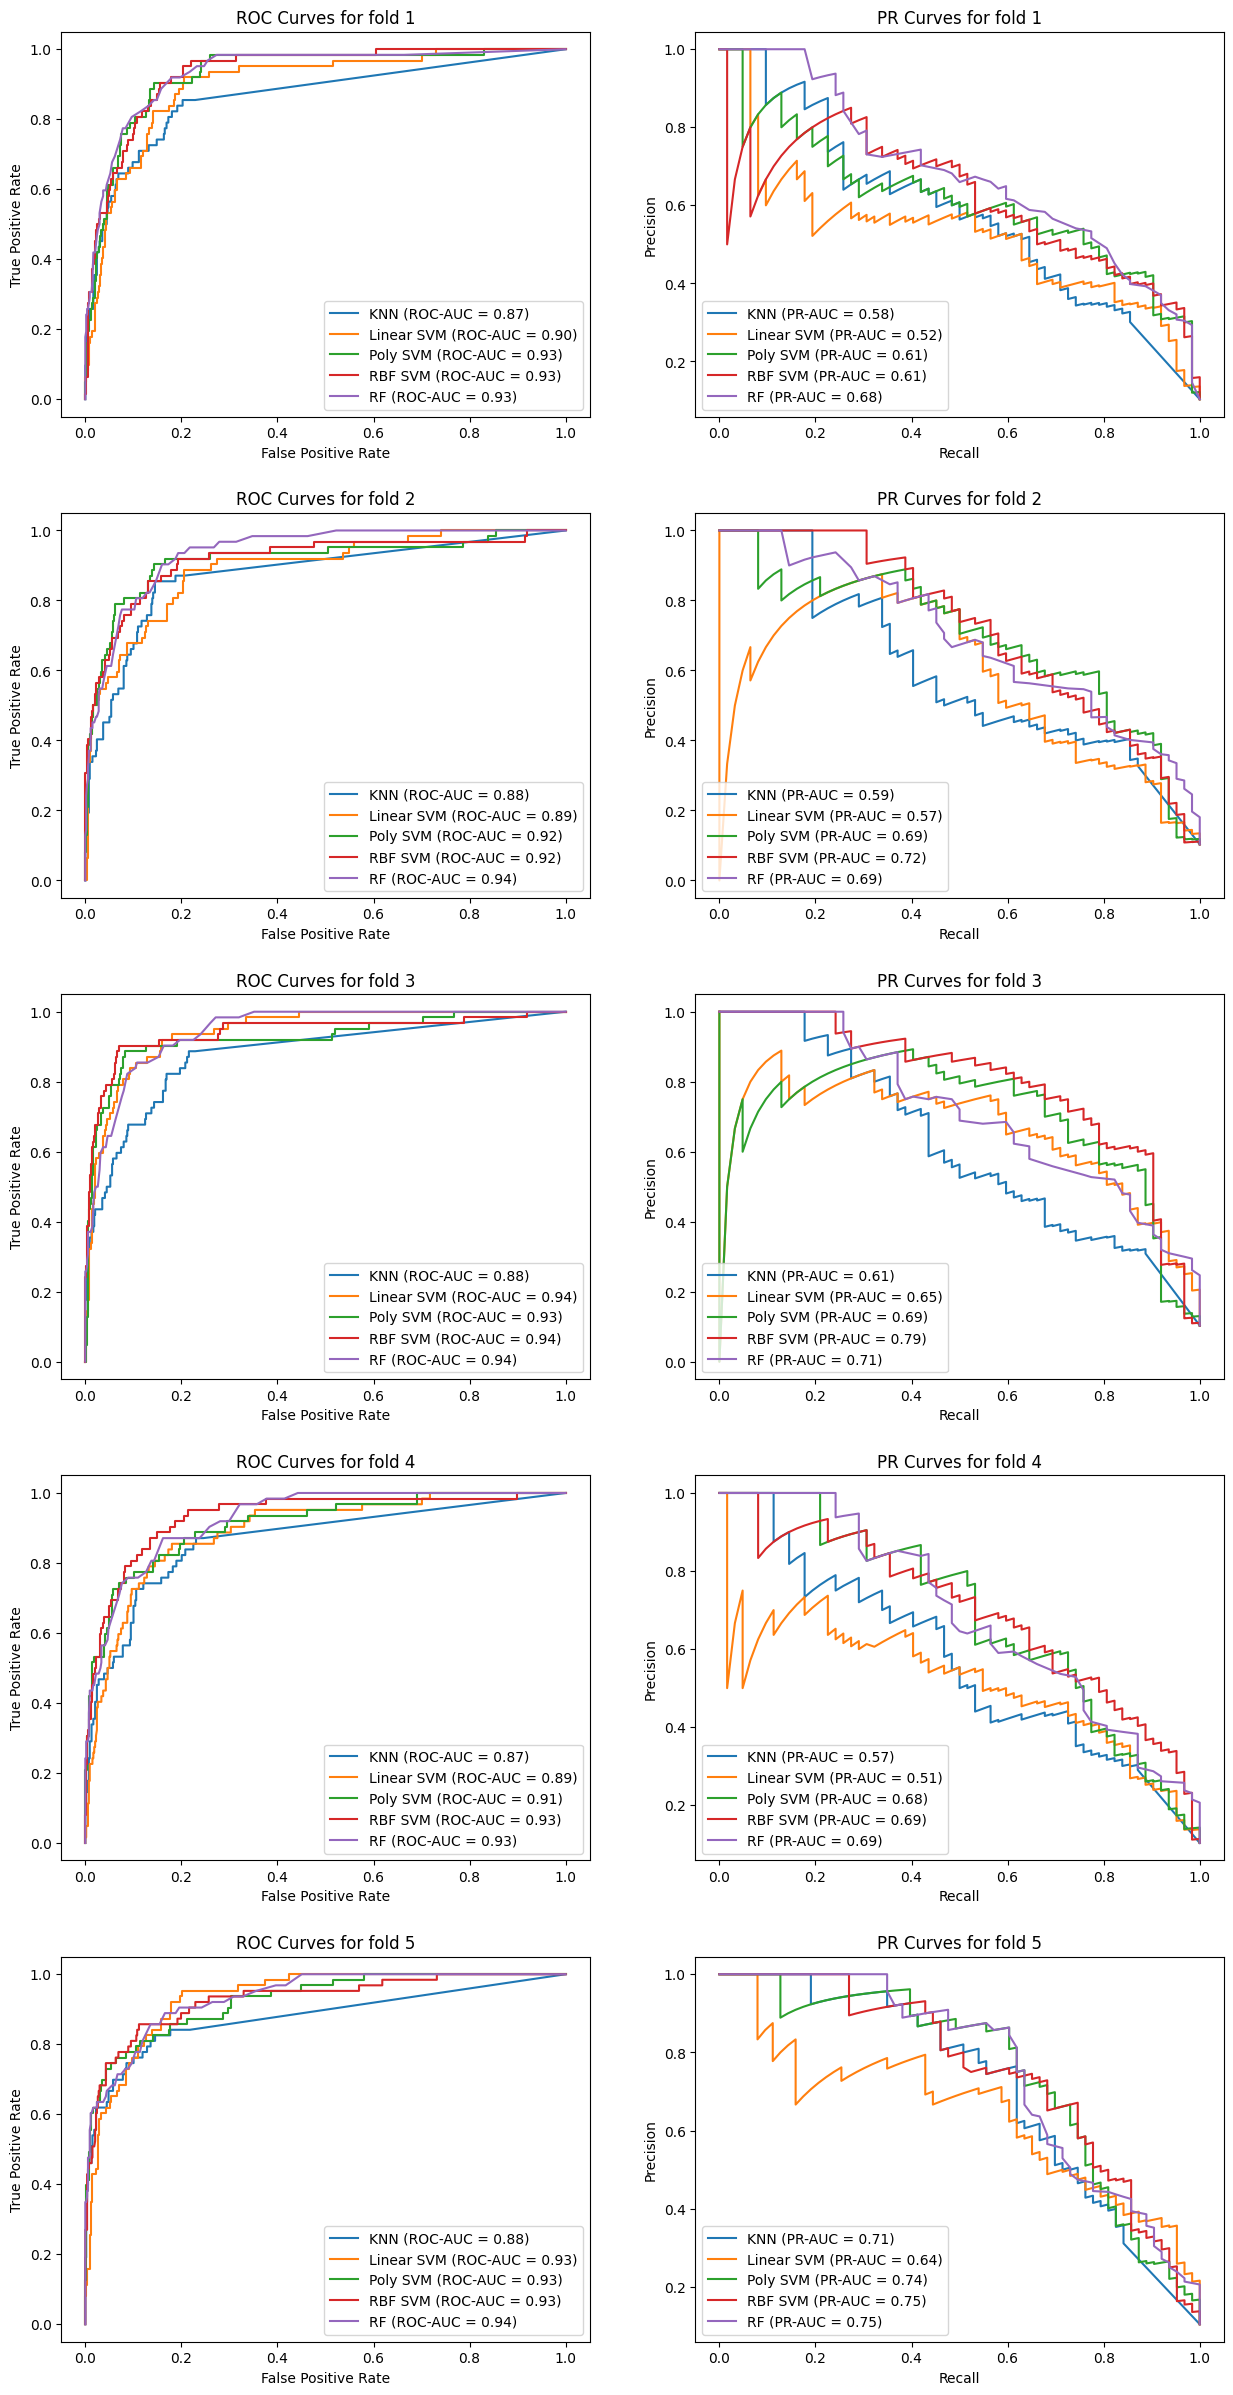

In [7]:
# Create subplots
fig, axs = plt.subplots(5, 2, figsize=(15, 30))
fig.subplots_adjust(hspace=0.25)

# 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True)
fold_index = 0

# Loop through each fold
for train_index, test_index in skf.split(Xtrain_standard, Ytrain):
    X_train_fold, X_test_fold = Xtrain_standard[train_index], Xtrain_standard[test_index]
    Y_train_fold, Y_test_fold = Ytrain[train_index], Ytrain[test_index]

    # Plot ROC and PR curves for each classifier
    for classifier_name, classifier in classifiers.items():
        classifier.fit(X_train_fold, Y_train_fold)

        # Get the probability scores for the positive class
        scores = classifier.predict_proba(X_test_fold)[:, 1]

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(Y_test_fold, scores)
        roc_auc = auc(fpr, tpr)

        # Compute precision-recall curve
        precision, recall, _ = precision_recall_curve(Y_test_fold, scores)
        pr_auc = auc(recall, precision)

        # Plot ROC curve
        axs[fold_index, 0].plot(fpr, tpr, label=f'{classifier_name} (ROC-AUC = {roc_auc:.2f})')

        # Plot PR curve
        axs[fold_index, 1].plot(recall, precision, label=f'{classifier_name} (PR-AUC = {pr_auc:.2f})')

    # Set plot details for ROC curve
    axs[fold_index, 0].set_title('ROC Curves for fold ' + str(fold_index+1))
    axs[fold_index, 0].set_xlabel('False Positive Rate')
    axs[fold_index, 0].set_ylabel('True Positive Rate')
    axs[fold_index, 0].legend(loc='lower right')

    # Set plot details for PR curve
    axs[fold_index, 1].set_title('PR Curves for fold ' + str(fold_index+1))
    axs[fold_index, 1].set_xlabel('Recall')
    axs[fold_index, 1].set_ylabel('Precision')
    axs[fold_index, 1].legend(loc='lower left')

    fold_index += 1

# Show the plots
plt.show()

### v. Write your observations about the ROC and PR curves. 

A good ROC curve (for our unbalanced dataset) should exhibit the following characteristic:

- **Steep Increase in the Beginning**: A good ROC curve would ascend sharply toward the top-left corner. This indicates that the model effectively identifies true positives while minimizing false positives.

A good PR curve should exhibit the following characteristics:

1. **Steep Increase in the Beginning**: A good PR curve often exhibits a steep increase in precision with a small decrease in recall, especially in the initial phase. This indicates that the model can identify positive instances with high confidence.

2. **Smoothness**: Abrupt changes or dips may suggest inconsistencies in the model's behavior.

Consider these, we may prefer RBF SVM as the best classifier, for its ROC curve ascends the most sharply toward the top-left corner when FPR is low, and its PR curve is relatively smooth compared to that of linear or polynomial SVM.